In [2]:
# import sys
# # insert at 1, 0 is the script path (or '' in REPL)
# sys.path.insert(1, '/Users/lirui/Downloads/IIB-Project/')
import sys
sys.path.insert(1, '/Users/kastu/OneDrive - University of Cambridge/Bakshi Lab/Barcode_Screening/')

import time
import random
import pickle
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from scipy import special
from tifffile import imread, imsave
from cell import Cell
from microscope import Microscope
from utils import normalize_image, get_noisy_background, generate_label
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage.util import random_noise
from pylab import gray
from skimage import img_as_float, img_as_ubyte
import mahotas as mh


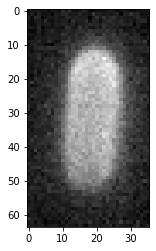

In [8]:
real_img = imread('/Volumes/Seagate Drive/Datasets/20171212_3FDAAs/Example Single Cells/BFP/No_segmentation/04_xy003_x1698_BFP.tif')
#real_img = imread('/Volumes/Seagate Drive/20180303_MM_SingleDyes/SYTO63_W1.5-T_Pos1-61/Example Single Cells/02_xy001_T01_CY5.tif')
real_img = normalize_image(real_img)
plt.imshow(real_img, cmap='gray')
plt.show()

Parameters:

In [9]:
waveLength = 460
locations = ['membrane', 'nucleoid']
one_type_each_channel = False
num_of_locs = len(locations)
max_l = 2800 #nm
outer_r_range = [400,510] #nm
trench_width = 1500 #nm
p_gen = 30 #nm/px
p_real = 65 #nm/px
image_size_real = np.array([64,36])
image_size = np.round(image_size_real*p_real).astype(int)  #np.array([5000, 1.5*trench_width]) #nm
print('Single-cell image size is',image_size_real)
image_size_gen = np.round(image_size/p_gen).astype(int)
periplasm_thickness_range = [40,50]#[80,110] #nm
brightness_cutoff = 0.29

camera_bias = 0.2
gauss_noise_sigma = 0.007

nucleoid_types = ['spherocylinder','twin-spherocylinder','sphere']
NA = 1.3
refractive_index = 1.515
centerloc = [random.gauss(0.5, 0.03), random.gauss(0.5, 0.03)]
for i in range(len(centerloc)):
    if centerloc[i]<0.4:
        centerloc[i]=0.4
    elif centerloc[i]>0.6:
        centerloc[i]=0.6

# for empty background generation, in normalized images
noise_mu = 0.5
noise_sigma = 0.14

Single-cell image size is [64 36]


Build cell and microscope models:

In [22]:
#outer_r = random.randint(outer_r_range[0], outer_r_range[1])
#l = random.randint(2*outer_r, max_l)
outer_r = 450
l=1700
centerloc = [0.55,0.5]
periplasm_thickness = 50#random.randint(periplasm_thickness_range[0], periplasm_thickness_range[1])


cell = Cell(l, outer_r, periplasm_thickness, "spherocylinder", p_gen, image_size_gen, brightness_cutoff, trench_width)
cell = cell.generate_3D_cell()
rotation = -3#-13#np.random.uniform(-cell.get_max_rotation_angle(), cell.get_max_rotation_angle(), 1)[0] #in degree

#label = generate_label(1, num_of_locs, one_type_each_channel, False).reshape((num_of_locs,))
label = [1,0]
print("Label is {}".format(label))

# microscope model
ch_microscope = Microscope(p_real, waveLength, NA, refractive_index)
# cell model      
objects3D = []
intensities = []
cutoff_options = []
if (1 in label):
    if label[0]==1:
        molecules_in_periplasm = cell.sample_from_component(cell.periplasm,1.0)
        objects3D.append(molecules_in_periplasm)
        intensities.append(0.16)
        cutoff_options.append(1)
    if label[1]==1:
        molecules_in_nucleoid = cell.sample_from_component(cell.nucleoid, 0.5)
        objects3D.append(molecules_in_nucleoid)
        intensities.append(0.5)
        cutoff_options.append(0)
    
    # include neighbour
    # molecules_in_neighbour = cell.sample_from_component(cell.neighbour, 0.3)
    # objects3D.append(molecules_in_neighbour)
    # intensities.append(0.3)
    # cutoff_options.append(0)


    channel_image = cell.get_greyScale_image(objects3D, intensities, cutoff_options, rotation, centerloc) #float image
    blurred_image = ch_microscope.convolve_with_Gaussian(channel_image, cell.p_gen)
    resized = ch_microscope.resize_image(blurred_image, image_size_real)

    noisy_resized_poisson = random_noise(resized, mode ='poisson') # add photon shot noise. Input is float image. The last number is unused.
    #noisy_resized = img_as_ubyte(0.5*normalize_image(noisy_resized))
    noisy_resized = 1*noisy_resized_poisson + camera_bias
    noisy_resized_gaussian = random_noise(noisy_resized, mode ='gaussian', mean = 0, var = gauss_noise_sigma**2) # add thermal noise
    #noisy_resized = noisy_resized + get_noisy_background(image_size_real, 1, camera_bias, gauss_noise_sigma)
    noisy_resized = normalize_image(noisy_resized_gaussian)
else:
    BG_type = np.random.choice([0,1],1, p=[0.7,0.3])
    if BG_type==0:
        noisy_resized = get_noisy_background(image_size_real, 1, noise_mu, noise_sigma)
    else:
        molecules_in_neighbour = cell.sample_from_component(cell.neighbour, 0.8)
        objects3D.append(molecules_in_neighbour)
        intensities.append(1)
        cutoff_options.append(0)

    #result_img = normalize_image(noisy_resized)

Label is [1, 0]


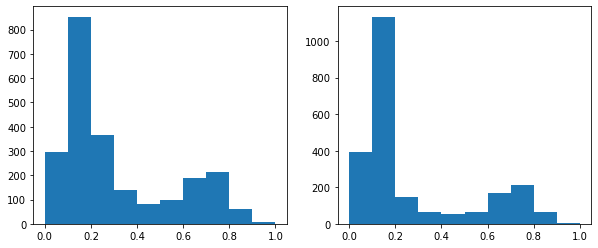

In [11]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ax[0].hist(real_img.flatten())
ax[1].hist(noisy_resized.flatten())
plt.show()

In [23]:
SSIM_resized_capping = []
MSE_resized_capping = []

SSIM_noisy_resized_poisson_capping = []
MSE_noisy_resized_poisson_capping = []

SSIM_noisy_resized_capping = []
MSE_noisy_resized_capping = []

0.26558051007379796 0.04542135710808021
0.2593622775835159 0.04311966904695838
0.37454764779280036 0.021186606227858347
[1]


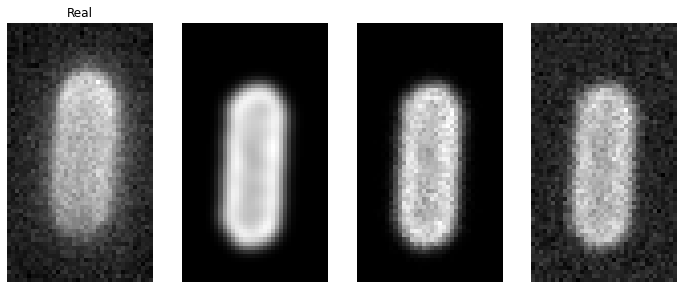

In [24]:
# syn_img = normalize_image(noisy_resized)
# print('SSIM:', ssim(syn_img, real_img, data_range=real_img.max() - real_img.min()))
# print("MSE:", mean_squared_error(syn_img, real_img))

fig,ax = plt.subplots(1,4,figsize=(12,6))
ax0=ax[0].imshow(real_img,cmap='gray')
ax[0].set_title('Real')

syn_img = normalize_image(resized)
ax1=ax[1].imshow(syn_img, cmap='gray')
SSIM = ssim(syn_img, real_img, data_range=real_img.max() - real_img.min())
MSE = mean_squared_error(syn_img, real_img)
# ax[1].set_title('SSIM:{}, MSE:{}'.format(SSIM, MSE))
print(SSIM, MSE)
SSIM_resized_capping.append(SSIM)
MSE_resized_capping.append(MSE)

syn_img = normalize_image(noisy_resized_poisson)
ax2=ax[2].imshow(syn_img, cmap='gray')
SSIM = ssim(syn_img, real_img, data_range=real_img.max() - real_img.min())
MSE = mean_squared_error(syn_img, real_img)
# ax[2].set_title('SSIM:{}, MSE:{}'.format(SSIM, MSE))
print(SSIM, MSE)
SSIM_noisy_resized_poisson_capping.append(SSIM)
MSE_noisy_resized_poisson_capping.append(MSE)

syn_img = normalize_image(noisy_resized)
ax3=ax[3].imshow(syn_img, cmap='gray')
SSIM = ssim(syn_img, real_img, data_range=real_img.max() - real_img.min())
MSE = mean_squared_error(syn_img, real_img)
# ax[3].set_title('SSIM:{}, MSE:{}'.format(SSIM, MSE))
print(SSIM, MSE)
SSIM_noisy_resized_capping.append(SSIM)
MSE_noisy_resized_capping.append(MSE)
# plt.colorbar(ax0, ax=ax[0])
# plt.colorbar(ax1, ax=ax[1])
print(cutoff_options)
for i in range(4):
    ax[i].axis('off')
plt.show()

In [21]:
print(len(SSIM_resized_capping))
print(np.mean(SSIM_resized_capping))
print(np.mean(MSE_resized_capping))

print(np.mean(SSIM_noisy_resized_poisson_capping))
print(np.mean(MSE_noisy_resized_poisson_capping))

print(np.mean(SSIM_noisy_resized_capping))
print(np.mean(MSE_noisy_resized_capping))

1
0.17713606036945473
0.05592054514997898
0.16906878062335537
0.05679633680855943
0.2557475386474074
0.04666976292499663


No intensity thresholding

In [191]:
SSIM_resized_no_capping = []
MSE_resized_no_capping = []

SSIM_noisy_resized_poisson_no_capping = []
MSE_noisy_resized_poisson_no_capping = []

SSIM_noisy_resized_no_capping = []
MSE_noisy_resized_no_capping = []

0.30847822982223905 0.03207331485894538
0.2984529035556948 0.031137540795020673
0.43728234784499376 0.013578781359012264
[0]


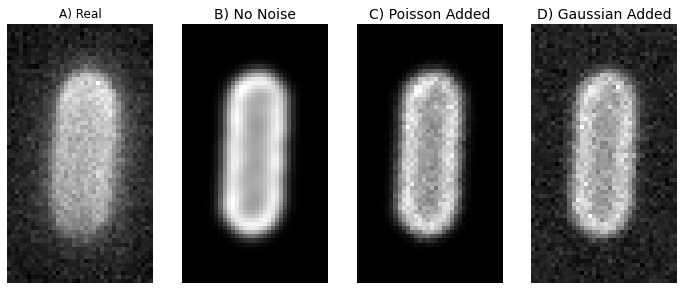

In [261]:
# syn_img = normalize_image(noisy_resized)
# print('SSIM:', ssim(syn_img, real_img, data_range=real_img.max() - real_img.min()))
# print("MSE:", mean_squared_error(syn_img, real_img))

fig,ax = plt.subplots(1,4,figsize=(12,6))
ax0=ax[0].imshow(real_img,cmap='gray')
ax[0].set_title('A) Real', fontsize=12)

syn_img1 = normalize_image(resized)
ax1=ax[1].imshow(syn_img1, cmap='gray')
SSIM = ssim(syn_img1, real_img, data_range=real_img.max() - real_img.min())
MSE = mean_squared_error(syn_img1, real_img)
ax[1].set_title('B) No Noise', fontsize=14)
print(SSIM, MSE)
SSIM_resized_no_capping.append(SSIM)
MSE_resized_no_capping.append(MSE)

syn_img2 = normalize_image(noisy_resized_poisson)
ax2=ax[2].imshow(syn_img2, cmap='gray')
SSIM = ssim(syn_img2, real_img, data_range=real_img.max() - real_img.min())
MSE = mean_squared_error(syn_img2, real_img)
ax[2].set_title('C) Poisson Added', fontsize=14)
print(SSIM, MSE)
SSIM_noisy_resized_poisson_no_capping.append(SSIM)
MSE_noisy_resized_poisson_no_capping.append(MSE)

syn_img3 = normalize_image(noisy_resized)
ax3=ax[3].imshow(syn_img3, cmap='gray')
SSIM = ssim(syn_img3, real_img, data_range=real_img.max() - real_img.min())
MSE = mean_squared_error(syn_img3, real_img)
ax[3].set_title('D) Gaussian Added', fontsize=14)
print(SSIM, MSE)
SSIM_noisy_resized_no_capping.append(SSIM)
MSE_noisy_resized_no_capping.append(MSE)

# plt.colorbar(ax0, ax=ax[0])
# plt.colorbar(ax1, ax=ax[1])
print(cutoff_options)
for i in range(4):
    ax[i].axis('off')
plt.show()

In [390]:
print(len(SSIM_resized_no_capping))
print(np.mean(SSIM_resized_no_capping))
print(np.mean(MSE_resized_no_capping))

print(np.mean(SSIM_noisy_resized_poisson_no_capping))
print(np.mean(MSE_noisy_resized_poisson_no_capping))

print(np.mean(SSIM_noisy_resized_no_capping))
print(np.mean(MSE_noisy_resized_no_capping))

18
0.31067825148688955
0.0313547492637707
0.3048749145557593
0.03079182413561367
0.43911103173314797
0.013327081271418191


In [85]:
cell2 = Cell(l, outer_r, periplasm_thickness, "twin-spherocylinder", p_gen, image_size_gen, brightness_cutoff, trench_width)
cell2 = cell2.generate_3D_cell()

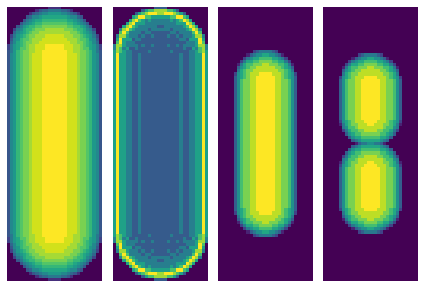

In [86]:
fig, axes = plt.subplots(1,4, figsize=(6,6))
axes[0].imshow(np.sum(cell.cell, axis=1))
#axes[0].set_title('cell')
axes[1].imshow(np.sum(cell.periplasm, axis=1))
#axes[1].set_title('membrane')
axes[2].imshow(np.sum(cell.nucleoid, axis=1))
#axes[2].set_title('nucleoid_1')
axes[3].imshow(np.sum(cell2.nucleoid, axis=1))
#axes[3].set_title('nucleoid_2')

for i in range(4):
    axes[i].axis('off')
plt.tight_layout()
plt.show()

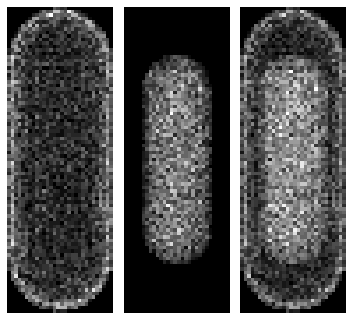

In [87]:
fig2, axes2 = plt.subplots(1,3,figsize=(5,6))
axes2[0].imshow(np.sum(molecules_in_periplasm,axis=1), cmap='gray')
#axes2[0].set_title('membrane')
axes2[0].axis('off')
axes2[1].imshow(np.sum(molecules_in_nucleoid,axis=1), cmap='gray')
#axes2[1].set_title('nucleoid')
axes2[1].axis('off')
axes2[2].imshow(np.sum(molecules_in_periplasm+molecules_in_nucleoid,axis=1), cmap='gray')
#axes2[2].set_title('both')
axes2[2].axis('off')
plt.tight_layout()
plt.show()

### Use SHINE to process the images -- sfMatch
Find the average tarmag

In [29]:
from pySHINE import lumMatch, sfMatch, cart2pol
directory = '/Volumes/Seagate Drive/20180303_MM_SingleDyes/SYTO63_W1.5-T_Pos1-61/Example Single Cells'

real_images = []
for idx, filename in enumerate(os.listdir(directory)):
    if idx>0:
        real = imread(directory+'/'+filename)
        real_images.append(real)

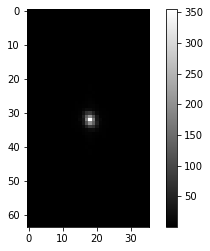

In [30]:
numin = len(real_images)
xs, ys = real_images[0].shape
angs = np.zeros((xs,ys,numin))
mags = np.zeros((xs,ys,numin))
for i in range(numin):
    img = normalize_image(real_images[i])
    xs1, ys1 = img.shape
    assert (xs == xs1) and (ys == ys1), 'All images must have the same size.'

    fftimg = np.fft.fftshift(np.fft.fft2(img))
    angs[:,:,i], mags[:,:,i] = cart2pol(np.real(fftimg),np.imag(fftimg))
    #mags[:,:,i] = 20*np.log(np.abs(fftimg))
    tarmag = np.mean(mags,2)

fig,ax = plt.subplots(1,1)
ax0=ax.imshow(tarmag,cmap='gray')
plt.colorbar(ax0, ax=ax)
plt.show()

In [37]:
#pickle.dump(tarmag, open( "/Volumes/Seagate Drive/20180303_MM_SingleDyes/SYTO63_W1.5-T_Pos1-61/Example Single Cells/CY5_tarmag.pkl", "wb" ) )

sfMatch this image

In [17]:
from pySHINE import lumMatch, sfMatch, cart2pol
tarmag = pickle.load(open('/Volumes/Seagate Drive/20171212_3FDAAs/Example Single Cells/sfMatch_target_spectra/RFP_tarmag.pkl', 'rb'))

In [18]:
real_img_byte = img_as_ubyte(real_img)
sfMatched = sfMatch([noisy_resized],rescaling=1,tarmag=tarmag)[0]
print(type(sfMatched[0,0]), np.max(sfMatched))

<class 'numpy.uint8'> 255


SSIM: 0.2789457788736812
MSE: 0.032407300610876155


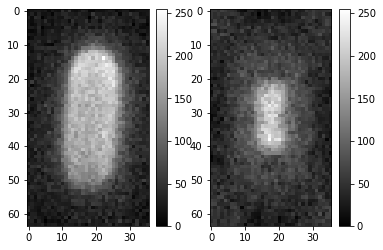

In [19]:
print('SSIM:', ssim(normalize_image(sfMatched), normalize_image(real_img_byte), data_range=normalize_image(real_img_byte).max() - normalize_image(real_img_byte).min()))
print("MSE:", mean_squared_error(normalize_image(sfMatched), normalize_image(real_img_byte)))

fig,ax = plt.subplots(1,2,figsize=(6,4))
ax0=ax[0].imshow(real_img_byte,cmap='gray')
ax1=ax[1].imshow(sfMatched, cmap='gray')
plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.show()

### Luminance Match
Get the M and S from multiple real images of the same channel.

In [31]:
mean_lst = []
std_lst = []
for i in range(len(real_images)):
    normalized = normalize_image(real_images[i])
    ubyte_image = img_as_ubyte(normalized)
    mean_lst.append(np.mean(ubyte_image))
    std_lst.append(np.std(ubyte_image))
M = np.mean(mean_lst)
S = np.mean(std_lst)
print('M:', M)
print('S:', S)

M: 39.24370659722222
S: 53.83895315557915


SSIM: 0.3813304577595982
MSE: 0.02035980736770182


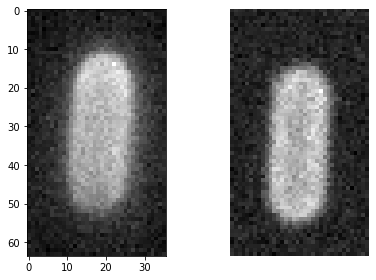

In [25]:
M = 83
S = 61
syn_img = img_as_ubyte(noisy_resized)
lumMatched = ((syn_img-np.mean(syn_img))/np.std(syn_img)) * S + M
#lumMatched = normalize_image(lumMatched)
lumMatched = lumMatched/255

print('SSIM:', ssim(lumMatched, real_img, data_range=real_img.max() - real_img.min()))
print("MSE:", mean_squared_error(lumMatched, real_img))

fig,ax = plt.subplots(1,2,figsize=(6,4))
ax0=ax[0].imshow(real_img,cmap='gray')
ax1=ax[1].imshow(lumMatched, cmap='gray')
# plt.colorbar(ax0, ax=ax[0])
# plt.colorbar(ax1, ax=ax[1])
plt.tight_layout()
ax[1].axis('off')
plt.show()

LumMatch does not alter the histogram much!

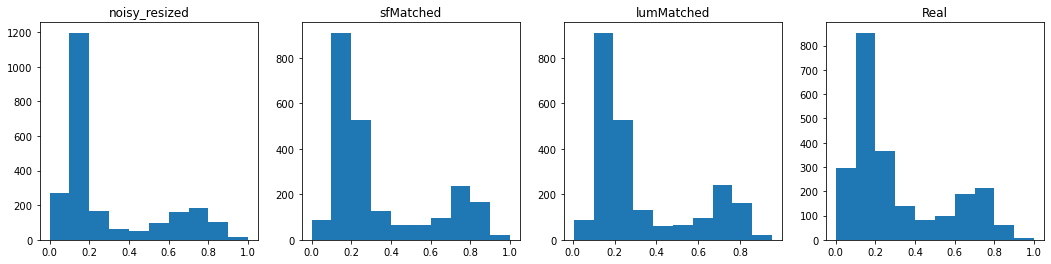

In [62]:
fig,ax = plt.subplots(1,4, figsize=(18,4))
ax[0].hist(noisy_resized.flatten())
ax[1].hist(normalize_image(sfMatched).flatten())
ax[2].hist(lumMatched.flatten())
ax[3].hist(real_img.flatten())


ax[0].set_title('noisy_resized')
ax[1].set_title('sfMatched')
ax[2].set_title('lumMatched')
ax[3].set_title('Real')
plt.show()

### Equate the histogram with skimage

SSIM: 0.44870662819034385
MSE: 0.012679807093087631


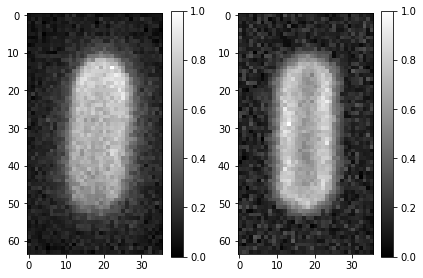

In [63]:
from skimage import exposure
from skimage.exposure import match_histograms

hist_equalized = match_histograms(noisy_resized, real_img)

print('SSIM:', ssim(hist_equalized, real_img, data_range=real_img.max() - real_img.min()))
print("MSE:", mean_squared_error(hist_equalized, real_img))

fig,ax = plt.subplots(1,2,figsize=(6,4))
ax0=ax[0].imshow(real_img,cmap='gray')
ax1=ax[1].imshow(hist_equalized, cmap='gray')
plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.tight_layout()
plt.show()


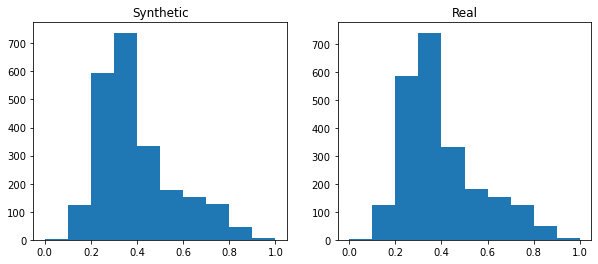

In [141]:
fig,ax = plt.subplots(1,2, figsize=(10,4))
ax[0].hist(hist_equalized.flatten())
ax[1].hist(real_img.flatten())
ax[0].set_title('Synthetic')
ax[1].set_title('Real')
plt.show()

### Denoising

SSIM: 0.6612867535899262
MSE: 0.006915135894281036


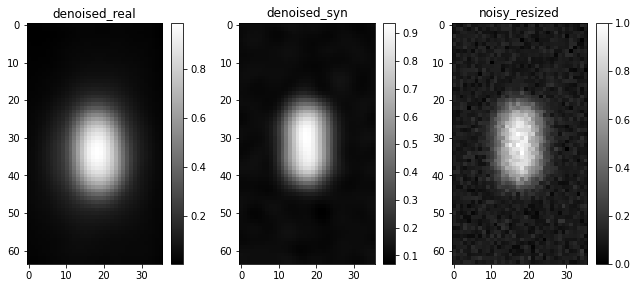

In [24]:
from utils import get_Butterworth_filter, filter_with_Butterworth

[height, width] = real_img.shape
Butterworth_H = get_Butterworth_filter(height, width, 5,8)
denoised_syn = filter_with_Butterworth(noisy_resized, Butterworth_H)
denoised_real = filter_with_Butterworth(real_img, Butterworth_H)

print('SSIM:', ssim(denoised_syn, denoised_real, data_range=denoised_real.max() - denoised_real.min()))
print("MSE:", mean_squared_error(denoised_syn, denoised_real))

fig,ax = plt.subplots(1,3,figsize=(9,4))
ax0=ax[0].imshow(denoised_real,cmap='gray')
ax[0].set_title('denoised_real')
ax1=ax[1].imshow(denoised_syn, cmap='gray')
ax[1].set_title('denoised_syn')
ax2=ax[2].imshow(noisy_resized,cmap='gray')
ax[2].set_title('noisy_resized')
plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.colorbar(ax2, ax=ax[2])
plt.tight_layout()
plt.show()




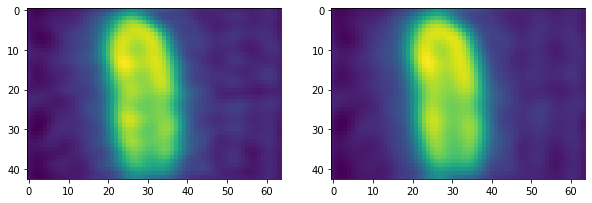

In [115]:
img = imread('/Volumes/Seagate Drive/20171212_3FDAAs/Extracted/xy003_T01/xy003_T01_channels/ch2_pos_114.5/BFP.tif')
img = img[273:316,:]
img = normalize_image(img)

[height, width] = img.shape
Butterworth_H = get_Butterworth_filter(height, width, 8,8)
restored = filter_with_Butterworth(img, Butterworth_H)
fig,ax = plt.subplots(1,2, figsize=(10,6))
ax[0].imshow(filter_with_Butterworth(img, Butterworth_H))
ax[1].imshow(filter_with_Butterworth(img, H))
plt.show()

Image type before denoising: Real: <class 'numpy.uint8'>, Synthetic: <class 'numpy.uint8'>.
Image type after denoising: Real: <class 'numpy.uint8'>, Synthetic: <class 'numpy.uint8'>.
SSIM: 0.44329254442936317
MSE: 452.64019097222223


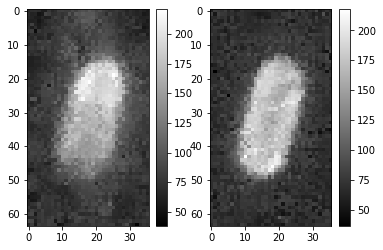

In [281]:
import cv2
# Denoising requires input images to be ubyte
real_img_ubyte = img_as_ubyte(real_img)
matched_img_ubyte = img_as_ubyte(lumMatched)
print('Image type before denoising: Real: {}, Synthetic: {}.'.format(type(real_img_ubyte[0,0]), type(matched_img_ubyte[0,0])))

restored_real = cv2.bilateralFilter(real_img_ubyte,7,sigmaColor=30,sigmaSpace=5, borderType=cv2.BORDER_DEFAULT)
restored_syn = cv2.bilateralFilter(matched_img_ubyte,7,sigmaColor=30,sigmaSpace=5, borderType=cv2.BORDER_DEFAULT)#filtersize, sigmacolor, sigmaspace

print('Image type after denoising: Real: {}, Synthetic: {}.'.format(type(restored_real[0,0]), type(matched_img_ubyte[0,0])))
print('SSIM:', ssim(restored_syn, restored_real, data_range=restored_real.max() - restored_real.min()))
print("MSE:", mean_squared_error(restored_syn, restored_real))

fig,ax = plt.subplots(1,2,figsize=(6,4))
ax0=ax[0].imshow(restored_real,cmap='gray')
ax1=ax[1].imshow(restored_syn, cmap='gray')
plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.show()


### Segment the cell out
Rectangular mask

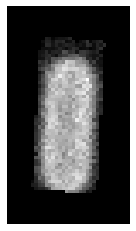

In [26]:
from utils import segment_synthetic_cell

final_img = segment_synthetic_cell(normalize_image(noisy_resized), cell, rotation, True, [0.5,0.5], erode=False)
plt.imshow(final_img,cmap='gray')
plt.axis('off')
plt.show()

Centroid at [0.5, 0.5]
<class 'numpy.bool_'> (64, 36)


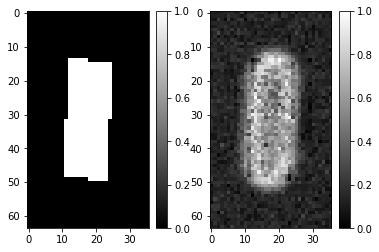

In [20]:
h, w1, w2 =  cell.cell.shape
# h = int(h*1.002)
# w1 = int(w1*1.002)

h = int(0.86*h)
w1 = int(0.86*w1)

mask_centerloc = [0.5,0.5]
print('Centroid at',[0.5,0.5])
mask = np.zeros((cell.image_size_gen[0], cell.image_size_gen[1]), dtype=np.float64)
topleftloc = np.round(np.multiply(mask_centerloc,cell.image_size_gen)-0.5*np.array([h,w1])).astype(int)


mask[topleftloc[0]:topleftloc[0]+h,topleftloc[1]:topleftloc[1]+w1] = 1

# Rotate and resize
# PIL_img = Image.fromarray(mask)
# rotated_PIL_mask = PIL_img.rotate(rotation, resample = Image.BILINEAR)
# rotated_mask = np.asarray(rotated_PIL_mask)

# # rotated_mask = rotated_mask>0
# # rotated_mask = img_as_ubyte(rotated_mask)
# # dilated_mask = mh.morph.dilate(rotated_mask)
# # dilated_mask = mh.morph.dilate(dilated_mask)
# # dilated_mask = mh.morph.dilate(dilated_mask)
# final_mask = ch_microscope.resize_image(rotated_mask, image_size_real)>0

# Resize and rotate
resized_mask = ch_microscope.resize_image(mask, image_size_real)
resized_mask = resized_mask>0
dilated_mask = mh.morph.erode(resized_mask)
dilated_mask = img_as_ubyte(dilated_mask)

PIL_img = Image.fromarray(dilated_mask)
rotated_PIL_mask = PIL_img.rotate(rotation, resample = Image.BILINEAR)
final_mask = np.asarray(rotated_PIL_mask)>0


print(type(final_mask[0,0]), final_mask.shape)

fig,ax = plt.subplots(1,2,figsize=(6,4))
ax0=ax[0].imshow(final_mask,cmap='gray')
ax1=ax[1].imshow(noisy_resized, cmap='gray')
plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.show()

In [21]:
max_y = np.max(np.where(final_mask>0)[0])
min_y = np.min(np.where(final_mask>0)[0])
max_x = np.max(np.where(final_mask>0)[1])
min_x = np.min(np.where(final_mask>0)[1])
new_final_mask = np.zeros(final_mask.shape)
new_final_mask[min_y:(max_y+1), min_x:(max_x+1)] = 1
final_mask = (new_final_mask>0)

<class 'numpy.float64'>


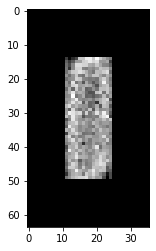

In [22]:
selected_vec = noisy_resized[final_mask]
min_val = np.min(selected_vec)
max_val = np.max(selected_vec)
noisy_resized[final_mask] = (selected_vec-min_val)/(max_val-min_val)
seg_synthetic = noisy_resized*final_mask
seg_synthetic = normalize_image(seg_synthetic)
print(type(seg_synthetic[0,0]))
plt.imshow(seg_synthetic, cmap='gray')
plt.show()

Cell mask

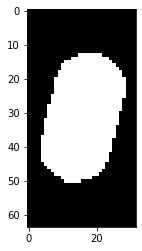

In [38]:

centerloc = [0.5,0.5]
mask = np.zeros((cell.image_size_gen[0], cell.image_size_gen[1]), dtype=np.float64)
projected = np.sum(cell.cell,axis=1)
isCell = img_as_ubyte(projected>0)

mask_height,mask_width = isCell.shape
centerloc = np.array(centerloc)
topleftloc = np.round(np.multiply(centerloc,cell.image_size_gen)-0.5*np.array(isCell.shape)).astype(int)
mask[topleftloc[0]:topleftloc[0]+mask_height,topleftloc[1]:topleftloc[1]+mask_width] = isCell

#Rotate first, then resize
PIL_img = Image.fromarray(mask)
rotated_PIL_mask = PIL_img.rotate(rotation, resample = Image.BILINEAR)
rotated_mask = np.asarray(rotated_PIL_mask)

rotated_mask = rotated_mask>0
rotated_mask = img_as_ubyte(rotated_mask)
dilated_mask = mh.morph.dilate(rotated_mask)
dilated_mask = mh.morph.dilate(dilated_mask)
dilated_mask = mh.morph.dilate(dilated_mask)
final_mask = ch_microscope.resize_image(dilated_mask, image_size_real)>0

plt.imshow(final_mask,cmap='gray')
plt.show()

<class 'numpy.float64'>


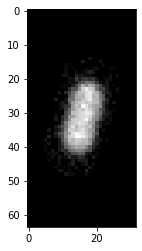

In [30]:
selected_vec = noisy_resized[final_mask]
min_val = np.min(selected_vec)
max_val = np.max(selected_vec)
noisy_resized[final_mask] = (selected_vec-min_val)/(max_val-min_val)
seg_synthetic = noisy_resized*final_mask
print(type(seg_synthetic[0,0]))
plt.imshow(seg_synthetic, cmap='gray')
plt.show()

These parts are not needed.

In [14]:
def get_cell_mask(cell, rotation, centerloc):
    img = np.zeros((cell.image_size_gen[0], cell.image_size_gen[1]))
    projected = np.sum(cell.cell,axis=1)
    mask = img_as_float(projected>0)

    img_height,img_width = mask.shape
    #object_img = (65535*object_img).astype('uint16')

    centerloc = np.array(centerloc)
    topleftloc = np.round(np.multiply(centerloc,cell.image_size_gen)-0.5*np.array(object_img.shape)).astype(int)
    img[topleftloc[0]:topleftloc[0]+img_height,topleftloc[1]:topleftloc[1]+img_width] = object_img
    # rotate objects
    PIL_img = Image.fromarray(img)
    rotated_PIL_img = PIL_img.rotate(rotation)
    rotated_img = np.asarray(rotated_PIL_img)
    return rotated_img #type=float

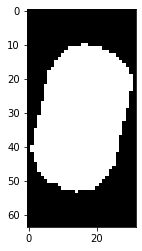

In [36]:
centerloc = [0.5,0.5]
mask = np.zeros((cell.image_size_gen[0], cell.image_size_gen[1]), dtype=np.float64)
projected = np.sum(cell.cell,axis=1)
isCell = img_as_ubyte(projected>0)

mask_height,mask_width = isCell.shape
centerloc = np.array(centerloc)
topleftloc = np.round(np.multiply(centerloc,cell.image_size_gen)-0.5*np.array(isCell.shape)).astype(int)
mask[topleftloc[0]:topleftloc[0]+mask_height,topleftloc[1]:topleftloc[1]+mask_width] = isCell

# Resize first, then rotate
resized_mask = ch_microscope.resize_image(mask, image_size_real)
resized_mask = img_as_ubyte(resized_mask>0)

PIL_img = Image.fromarray(resized_mask)
rotated_PIL_mask = PIL_img.rotate(rotation,resample = Image.BILINEAR)
rotated_mask = np.asarray(rotated_PIL_mask)>0
rotated_mask = img_as_ubyte(rotated_mask)
dilated_mask = mh.morph.dilate(rotated_mask)
dilated_mask = mh.morph.dilate(dilated_mask)
dilated_mask = mh.morph.dilate(dilated_mask)

plt.imshow(dilated_mask,cmap='gray')
plt.show()

### Examine the data generated by dataGenerator

In [6]:
data = pickle.load( open(r"C:\Users\kastu\OneDrive - University of Cambridge\Bakshi Lab\Barcode_Screening\ML_model\ch_training_data\synthetic_data_131024.pkl", "rb" ) )
print('Input data shape is', data1[0].shape)
image_shape = (data1[0][0].shape[0], data1[0][0].shape[1])
print('Image shape is {}.    There are {} images'.format(image_shape, data1[0].shape[0]))

Input data shape is (100, 64, 36, 1)
Image shape is (64, 36).    There are 100 images


[[3.]
 [3.]
 [3.]
 [0.]
 [1.]]


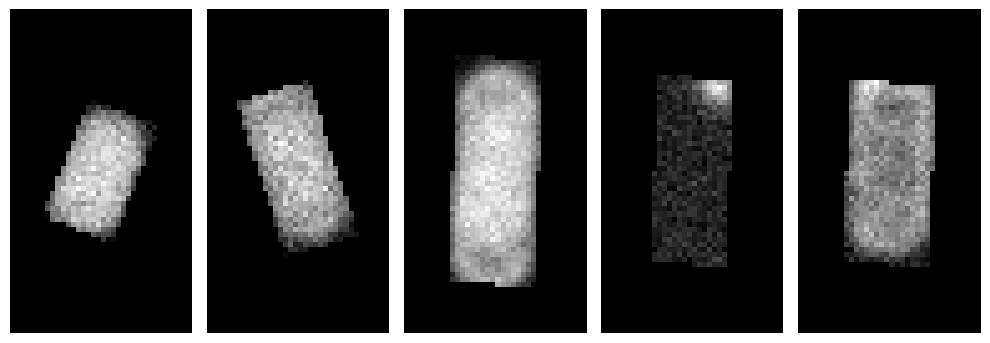

In [7]:
idx = 2
idx*=5
print(data[1][idx:idx+5])
fig, ax = plt.subplots(1,5,figsize=(10,4))
ax0 = ax[0].imshow(data[0][idx,:,:,0], cmap='gray')
ax1 = ax[1].imshow(data[0][idx+1,:,:,0], cmap='gray')
ax2 = ax[2].imshow(data[0][idx+2,:,:,0], cmap='gray')
ax3 = ax[3].imshow(data[0][idx+3,:,:,0], cmap='gray')
ax4 = ax[4].imshow(data[0][idx+4,:,:,0], cmap='gray')

for i in range(5):
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [8]:
selected_imgs = [
    data[0][25,:,:,0],
    data[0][28,:,:,0],
    data[0][26,:,:,0],
    data[0][15,:,:,0],

    data[0][29,:,:,0],
    data[0][0,:,:,0],
    data[0][16,:,:,0],
    data[0][27,:,:,0]
] 
labels_for_selected = [0,1,2,3,5,4,6,7]


0
1
2
3
5
4
6
7


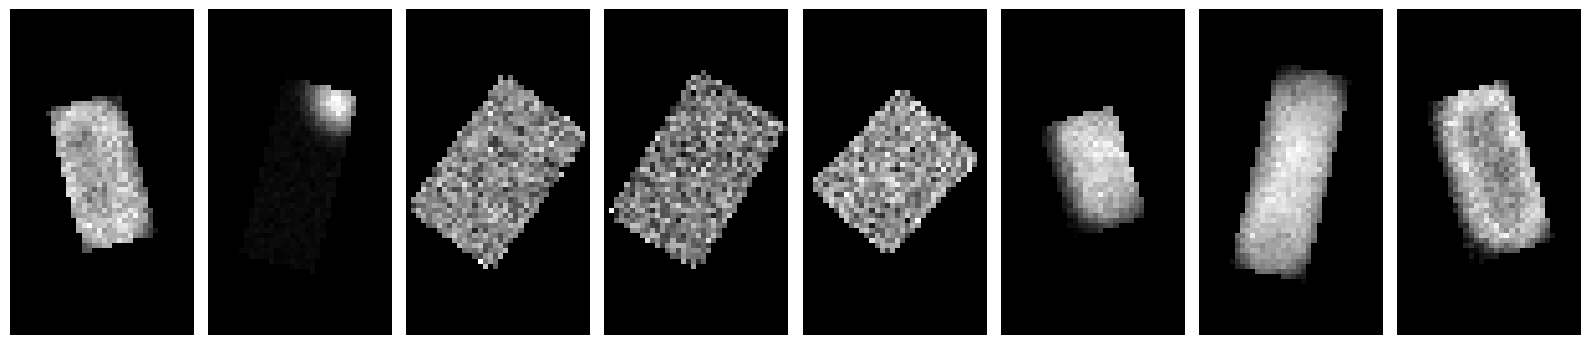

In [9]:
fig, ax = plt.subplots(1,len(selected_imgs),figsize=(2*len(selected_imgs),4))
for i in range(len(selected_imgs)):
    ax[i].imshow(selected_imgs[i], cmap='gray')
    ax[i].axis('off')
    print(labels_for_selected[i])

plt.tight_layout()
plt.show()

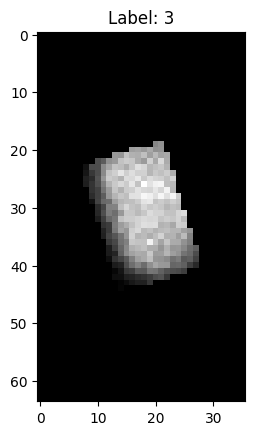

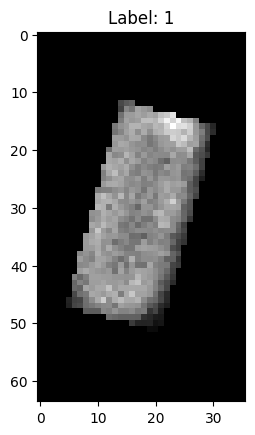

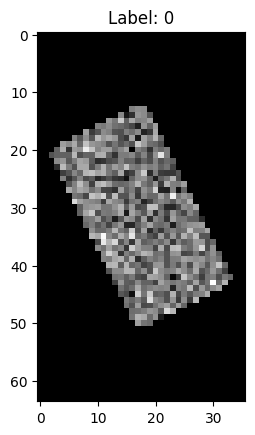

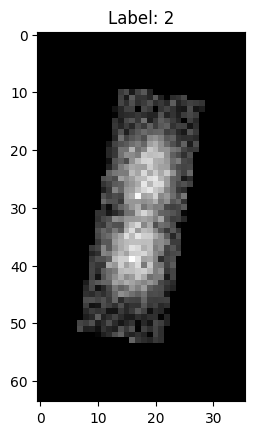

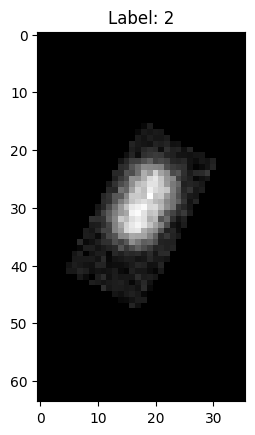

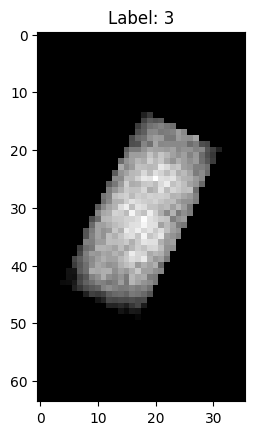

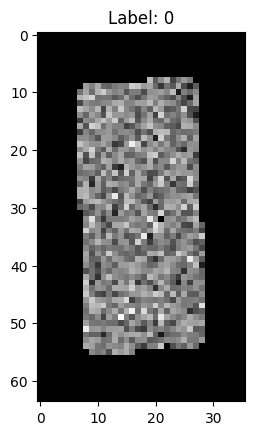

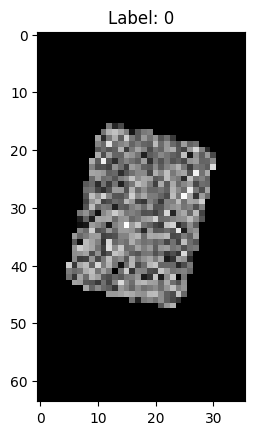

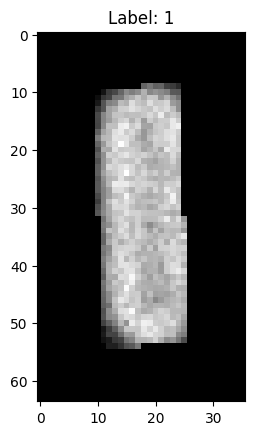

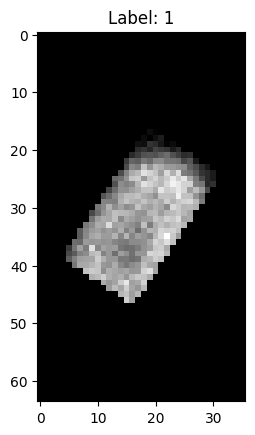

In [10]:
# Path to the pickle file
pkl_file_path = r"C:\Users\kastu\OneDrive - University of Cambridge\Bakshi Lab\Barcode_Screening\ML_model\ch_training_data\synthetic_data_131024.pkl"

# Load the data from the pickle file
with open(pkl_file_path, 'rb') as file:
    training_data = pickle.load(file)

# Extract images and labels from the training data
all_images, all_labels = training_data

# Visualize the first 10 images
for i in range(10):
    plt.imshow(all_images[i, :, :, 0], cmap='gray')  # Assuming the images are grayscale
    plt.title(f"Label: {int(all_labels[i])}")
    plt.show()
